# ML Pipeline for the UNITI dataset

## Purpose of this notebook
- [x] Prepare dataframe for ML
- [ ] Perform different split approaches to get different model solutions
    - [x] Answer-Cut
    - [ ] Time-Cut
    - [ ] User-wise 
    - [ ] Average-user
    - [ ] Group-wise
- [ ] Evalulate all approaches in one table in terms of performance and robustness

In [1]:
# imports
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read in df
df = pd.read_csv('../../data/d02_processed/uniti/uniti.csv', index_col='answer_id')

## Prepare dataframe for ML

Define test data to evaluate all approaches on the same testset.

20 % of the users shall be taken for test, 80 % for trying out different approaches.

In [3]:
# define list of users
users_list = df.user_id.unique()
# 20 % into train users
test_users = pd.Series(users_list).sample(frac=0.2, random_state=1994).to_list()
# 80 % into test users
train_users = [x for x in users_list if x not in set(test_users)]
# unit test 1
assert set(train_users + test_users) == set(users_list)
# unit test 2
assert test_users[:20] == [18153,40272,40135,2355,2325,34144,6180,6724,2110,36262,40402,40273,40311,2118,2317,6692,42321,42686,42678,36478]

# get train and test dataframe
# use train to check approaches, use test to validate approaches
df_train = df[df['user_id'].isin(train_users)]
df_test = df[df['user_id'].isin(test_users)]

In [5]:
# define features and target
features = ['loudness', 'cumberness', 'jawbone', 'neck', 'tin_day', 'tin_cumber', 'tin_max', 'movement', 'stress', 'emotion']
target = ['cumberness_t1']

# get train and test subsets for X and y
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# make cumberness a classification instead of regression for the target, not for the feature
y_train = pd.cut(y_train.cumberness_t1, bins=5)
y_test = pd.cut(y_test.cumberness_t1, bins=5)

# LabelEncoder
LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
# get class mapping as dict
mapping = dict(zip(range(len(LE.classes_)), LE.classes_))

## Perform different split approaches to get different model solutions

### Approach | Answer-cut

In [6]:
# instantiate model
model = RandomForestClassifier(random_state=1994)

# train model
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1994)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

# refit on all training data
model.fit(X_train, y_train)

# evaluate on test set
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred, average='weighted')
final_score = f1_score_test - 0.5 * scores.std()

print('f1_weighted testscore: ', f1_score_test)

Performance within train
f1_weighted mean  0.5884393749165102
standarddeviation  0.0034182248462100934
f1_weighted testscore:  0.5351539249809311


In [7]:
# TODO: What is baseline? Last cumberness? Average cumberness`? Majority cumberness?

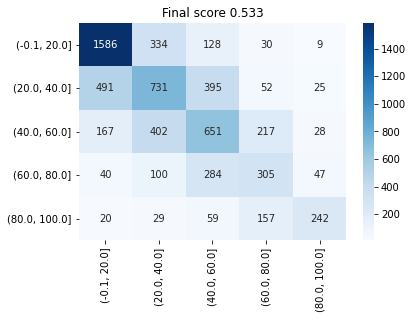

In [8]:
# visualize confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cm_array_df = pd.DataFrame(cf_matrix, index=list(mapping.values()), columns=list(mapping.values()))
sns.heatmap(cm_array_df, annot=True, cmap='Blues', fmt='')
plt.title(f'Final score {round(final_score, 3)}')
plt.show()

## Evalulate all approaches in one table in terms of performance and robustness